In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from models import LinearAutoEncoder, ConvAutoEncoder, BaselineClassifier, LinearClassifier
from sklearn.metrics import f1_score

## Dataset Loading

In [2]:
import json, gzip

class MNIST_Dataset(Dataset):
    def __init__(self, json_data) -> None:
        self.features = [torch.FloatTensor(i['image']).view(28,28) for i in json_data]
        self.labels = [torch.LongTensor([i['label']]) for i in json_data]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = None
dev_dataset = None
test_dataset = None

with gzip.open('mnist_rowmajor.jsonl.gz') as file:
    trainval_data = []
    test_data = []

    for sample in [json.loads(line) for line in file]:
        sample['image'] = sample['image']
        if sample['split'] == 'train':
            trainval_data.append(sample)
        else:
            test_data.append(sample)

    train_dataset = MNIST_Dataset(trainval_data[:50000])
    dev_dataset = MNIST_Dataset(trainval_data[50000:])
    test_dataset = MNIST_Dataset(test_data)

In [3]:
BATCH_SIZE = 100

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Question 2b

### Training Function

In [4]:
def train_encoder(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, max_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Dev":^10}')
    prev_loss = 2000000000
    # epoch loop
    for epoch in range(max_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        train_total_loss = 0
        total_num = 0
        for x, _ in train_dataloader:
            x = x.cuda()
            # forward pass
            pred_x = model.forward(x)
            # calculate gradients
            loss = criterion(pred_x, x)
            loss.backward()
            # update statistics
            train_total_loss += loss.item()
            total_num += 1
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        print(f'{train_total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, _ in dev_dataloader:
            x = x.cuda()
            # forward pass
            pred_x = model.forward(x)
            # update statistics
            total_loss += criterion(pred_x, x).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')
        # 
        # check convergence
        # 
        if train_total_loss > prev_loss:
            return
        prev_loss = train_total_loss

### Training

In [5]:
encoder_linear = LinearAutoEncoder().cuda()
train_encoder(encoder_linear, nn.BCELoss(), optim.Adam(encoder_linear.parameters(), lr=0.01), 100)

             Train       Dev    
Epoch 1     0.18632    0.14194  
Epoch 2     0.13556    0.13078  
Epoch 3     0.12805    0.12528  
Epoch 4     0.12482    0.12382  
Epoch 5     0.12314    0.12225  
Epoch 6     0.12209    0.12151  
Epoch 7     0.12118    0.12049  
Epoch 8     0.12062    0.11971  
Epoch 9     0.12026    0.11960  
Epoch 10    0.11971    0.12073  
Epoch 11    0.11929    0.11858  
Epoch 12    0.11916    0.11949  
Epoch 13    0.11881    0.11822  
Epoch 14    0.11867    0.11986  
Epoch 15    0.11850    0.11773  
Epoch 16    0.11819    0.11956  
Epoch 17    0.11800    0.11951  
Epoch 18    0.11814    0.11764  


In [6]:
encoder_conv = ConvAutoEncoder().cuda()
train_encoder(encoder_conv, nn.BCELoss(), optim.Adam(encoder_conv.parameters(), lr=0.01), 100)

             Train       Dev    
Epoch 1     0.18558    0.13255  
Epoch 2     0.12722    0.12303  
Epoch 3     0.12160    0.11923  
Epoch 4     0.11843    0.11716  
Epoch 5     0.11627    0.11472  
Epoch 6     0.11447    0.11365  
Epoch 7     0.11359    0.11249  
Epoch 8     0.11252    0.11179  
Epoch 9     0.11202    0.11221  
Epoch 10    0.11137    0.11170  
Epoch 11    0.11102    0.11233  
Epoch 12    0.11064    0.11087  
Epoch 13    0.11036    0.10992  
Epoch 14    0.10998    0.10949  
Epoch 15    0.10976    0.10997  
Epoch 16    0.10957    0.10982  
Epoch 17    0.10938    0.11035  
Epoch 18    0.10929    0.10950  
Epoch 19    0.10910    0.10988  
Epoch 20    0.10914    0.10905  


### Display

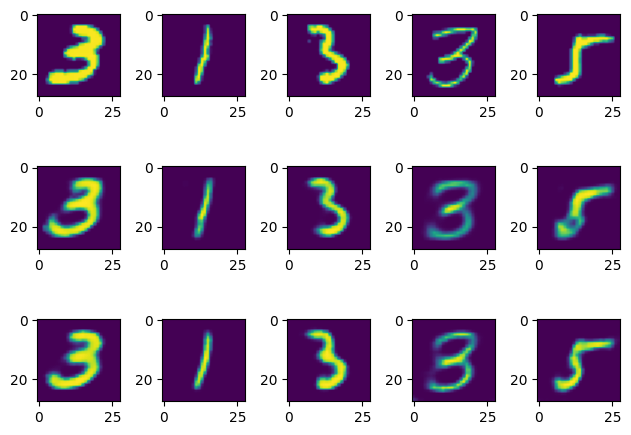

In [7]:
import random
fig, (row1, row2, row3) = plt.subplots(3, 5)

for i in range(5):
    x = dev_dataset[random.randint(0,10000-1)][0].cuda()
    x_pred_linear = encoder_linear.forward(x, detach=True).view(28,28)
    x_pred_conv = encoder_conv.forward(x, detach=True).view(28,28)

    row1[i].imshow(x.cpu())
    row2[i].imshow(x_pred_linear.cpu())
    row3[i].imshow(x_pred_conv.cpu())

plt.tight_layout()
plt.show()

## Question 2c

### Training Functions

In [8]:
def train_baseline(model: BaselineClassifier, criterion: nn.Module, num_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Test":^10}')
    prev_loss = 2000000000
    # epoch loop
    for epoch in range(num_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        train_total_loss = 0
        total_num = 0
        for x, y in train_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            pred_y = model.forward(x)
            # update statistics
            train_total_loss += criterion(pred_y, y).item()
            total_num += 1
            # backward pass
            for y_i in y:
                model.w[y_i] += 1
        print(f'{train_total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in test_dataloader:
            x = x.cuda()
            y = y.view(-1)
            # forward pass
            pred_y = model.forward(x)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')
        # 
        # check convergence
        # 
        if abs(train_total_loss - prev_loss) < 1:
            return
        prev_loss = train_total_loss

In [9]:
def train_classifier(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer,
                     encoder: nn.Module, max_epoch = 1):
    print(f'{"":<10} {"Train":^10} {"Test":^10}')
    prev_loss = 2000000000
    # epoch loop
    for epoch in range(max_epoch):
        print(f'{f"Epoch {epoch+1}":<10}', end=' ')
        # 
        # training loop
        # 
        train_total_loss = 0
        total_num = 0
        for x, y in train_dataloader:
            x = x.cuda()
            y = y.view(-1).cuda()
            # forward pass
            z = encoder.forward(x).detach()
            pred_y = model.forward(z)
            # calculate gradients
            loss = criterion(pred_y, y)
            loss.backward()
            # update statistics
            train_total_loss += loss.item()
            total_num += 1
            # backward pass
            optimizer.step()
            optimizer.zero_grad()
        print(f'{train_total_loss/total_num:^10.5f}', end=' ')
        # 
        # eval loop
        # 
        total_loss = 0
        total_num = 0
        for x, y in test_dataloader:
            x = x.cuda()
            y = y.view(-1).cuda()
            # forward pass
            z = encoder.forward(x).detach()
            pred_y = model.forward(z)
            # update statistics
            total_loss += criterion(pred_y, y).item()
            total_num += 1
        print(f'{total_loss/total_num:^10.5f}')
        # 
        # check convergence
        # 
        if abs(train_total_loss - prev_loss) < 1:
            return
        prev_loss = train_total_loss

### Training

In [10]:
classifier_base = BaselineClassifier().cuda()
train_baseline(classifier_base, nn.CrossEntropyLoss(), 100)

             Train       Test   
Epoch 1     2.35003    2.34765  
Epoch 2     2.34925    2.34765  


In [11]:
classifier_linear = LinearClassifier().cuda()
train_classifier(classifier_linear, nn.CrossEntropyLoss(), optim.Adam(classifier_linear.parameters(), lr=0.001),
                 encoder_conv, 100)

             Train       Test   
Epoch 1    

 0.46917    0.27476  
Epoch 2     0.24728    0.22637  
Epoch 3     0.21165    0.20556  
Epoch 4     0.18817    0.19263  
Epoch 5     0.17473    0.17659  
Epoch 6     0.16187    0.17807  
Epoch 7     0.15300    0.17302  
Epoch 8     0.14643    0.17724  
Epoch 9     0.13857    0.16067  
Epoch 10    0.13324    0.16933  
Epoch 11    0.12763    0.16718  
Epoch 12    0.12306    0.16967  
Epoch 13    0.11801    0.17217  
Epoch 14    0.11408    0.16940  
Epoch 15    0.11014    0.17228  
Epoch 16    0.10726    0.17294  
Epoch 17    0.10362    0.16559  
Epoch 18    0.10204    0.17080  
